# Task 7: Shopper sentiments

- The ShopperSentiments dataset, comprising over 250,000 customer reviews on
TeePublic, provides key insights for online fashion retail. Attributes include
reviewer_id, store_location, date, title, review, and review-label (rating 1 to 5).
- With unique features like geospatial coordinates and temporal data, it's a valuable
resource for sentiment analysis, geospatial patterns, temporal trends, and review
categorization.
- TeePublic's diverse fashion collection is the backdrop for understanding customer
sentiments and preferences.

# Shopper Sentiments dataset

## Description
This extensive dataset, comprised of over 250,000 customer reviews, offers a detailed exploration of customer experiences on TeePublic, an online platform renowned for its diverse collection of fashion items. The dataset spans crucial information, including `reviewer_id`, `store_location`, `latitude`, `longitude`, `date`, `month`, `year`, `title`, `review`, and the `review-label` indicating a rating on a scale of 1 to 5.

## Columns description
`reviewer_id`: A unique identifier for each reviewer, ensuring anonymity and privacy.
`store_location`: Geographic information specifying the location of the TeePublic fashion store.
`latitude`: The latitude coordinate of the store's location, providing precise geospatial data.
`longitude`: The longitude coordinate of the store's location, offering detailed geographic insights.
`date`: The specific date when the review was posted, enabling temporal analysis.
`month`: The month in which the review was posted, facilitating monthly trends exploration.
`year`: The year of the review, allowing for yearly analysis and trend identification.
`title`: The title associated with each review, capturing succinct sentiments or key points.
`review`: The textual content of the review, presenting detailed feedback from customers.
`review-label`: The reviewer's rating on a scale from 1 to 5, providing a quantitative measure of satisfaction.

## Store where data came from information:
TeePublic is a prominent online platform celebrated for its extensive collection of fashion items, including apparel, accessories, and more. This dataset, comprising reviews from the fashion store, serves as a valuable resource to understand customer sentiments and preferences within the dynamic landscape of online fashion retail.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ydata_profiling import ProfileReport
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from warnings import filterwarnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

filterwarnings('ignore')
%matplotlib inline

Retrieving data from Kaggle API, (using local machine)

In [5]:
# # Local PC data retrieving
# from kaggle.api.kaggle_api_extended import KaggleApi

# # Initialize the Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Download the dataset
# api.dataset_download_files('nelgiriyewithana/shoppersentiments', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw/TeePublic_review.csv", encoding='latin1')
df.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


Retrieving data from Kaggle API, (using Google Colab)

In [6]:
# # Google Colab data retrieving
# from google.colab import files

# # Uploading the Kaggle API key (kaggle.json) to Colab
# files.upload()

# # Move the uploaded file to the required location of Colab
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d nelgiriyewithana/shoppersentiments #dataset download
# !unzip -q shoppersentiments.zip #unzipping the data

# df = pd.read_csv("TeePublic_review.csv", encoding='latin1') #reading data as pandas dataframe

# Data cleaning and overview of the data

ProfileReport of the data

From this firts ProfileReport it can be concluded the following:
- The dataset is mid-high dimensionality with more than $278.000$ rows and 10 predictor variables.
- The data has nulls, specifically in the `review` column, with more than $11 \%$ nulls of total data.
- `reviewer_id` is an useless column, it has to be deleted.
- Sells reviews increase in month 12, apparently December.
- Most of the reviews are from US products.
- The `review` and `title` variables have many stopwords and they are the most common as excpected, it has to be made a treatment of this for sentiment analysis.
- Most reviews are good.
- The `review` and `title` variables are the ones with null data.

In [7]:
# report = ProfileReport(df)
# report

Analysis of unique values

By this analysis it can be concluded that the `year` column has not any relationship with the date-related columns, also by the correlation heatmap given by the ProfileReport, these variables have almost nothing in common and it's weird that in the dataset description it is not mentioned what exactly this column is. Is not the year the review was made because are years more than the present one, (2024), so I decide to eliminate this column based on its unclear proccedence.

In [8]:
print(f'The types of data in the dataset are: \n{df.dtypes}')

The types of data in the dataset are: 
reviewer_id       float64
store_location     object
latitude          float64
longitude         float64
date                int64
month               int64
year               object
title              object
review             object
review-label        int64
dtype: object


In [9]:
for i in df.columns:
    if i not in ['title', 'review', 'latitude', 'longitude']:
        print(f'Unique values for column {i} are: {df[i].unique()}')

Unique values for column reviewer_id are: [0.00000e+00 1.00000e+00 2.00000e+00 ... 2.78097e+05 2.78098e+05
         nan]
Unique values for column store_location are: ['US' 'CA' 'GB' 'AU' 'NZ' 'DE' 'BG' 'NL' 'SE' 'MY' 'NO' 'MA' 'IN' 'IT'
 'JP' 'PT' 'BE' 'FR' 'CH' 'HU' 'SG' 'TH' 'HK' 'SI' 'AT' 'CZ' 'UA' 'ID'
 'RO' 'ES' 'MX' 'IL' 'RS' 'PK' 'GI' 'SK' 'FI' 'LT' 'IE' 'PR' 'GU' 'LU'
 'JO' 'AE' 'IS' 'PL' 'HR' 'EC' 'BR' 'TR' 'DK' 'MT' 'BS' 'CY' 'CO' 'JM'
 'TW' 'NC' 'DO' 'CK' 'KR' 'MR' 'HT' 'VN' 'SR' 'EE' 'RU' 'PA' 'PH' 'CR'
 'IM' 'KH' 'EG' 'DZ' 'VE' 'NI' 'BH' 'CL' 'BM' 'TC' 'LK' 'SA' 'GR' 'BO'
 'AR' 'GT' 'TN' 'LV' 'CN' 'GD' 'ZA' 'QA' 'UY' 'AF' 'KW' 'BD' 'KZ' 'KY'
 'SV' 'KE' 'MD' 'PE' 'AX' 'GY' 'TT' 'HN' 'GP' 'PY' 'SY' 'VI' 'WS' 'BB'
 'GE' 'IQ' 'LB' 'TZ' 'NG' 'OM' 'SX' 'LI' 'LC' 'MN' 'GG' 'MK' 'BZ' 'JE'
 'MM' 'CM' 'MV' 'UZ' 'BA' 'PF' 'GF' 'GH' 'AW' 'MZ' 'CI' 'MW' 'CW' 'MO'
 'UG']
Unique values for column date are: [2023 2022 2021 2020 2019 2018]
Unique values for column month are: [ 6  3  5  4  

Eliminating unimportant columns

In [10]:
df.drop(['year', 'reviewer_id'], axis=1, inplace=True)

Information about nulls, infinite values and duplicates on the data

In [11]:
nulls = df.isnull()
duplicated_rows = df.duplicated()

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {duplicated_rows.sum()}')
print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')
print(f'Percentage of total null data: {df.isnull().sum().sum() / df.shape[0] * 100:.1f}%')

Total of null data: 30515
Total of duplicated data: 1536
Percentage of total duplicated data: 0.6%
Percentage of total null data: 11.0%


In [12]:
# Dropping duplicated rows
df = df.copy()[~duplicated_rows]

Renaming columns so it has a clear pattern

In [13]:
new_columns = [column.replace('-', '_') for column in df.columns]
df.columns = new_columns
print(f'New columns names: {df.columns}')

New columns names: Index(['store_location', 'latitude', 'longitude', 'date', 'month', 'title',
       'review', 'review_label'],
      dtype='object')


From the ProfileReport it can be concluded that the `review` and `title` columns are the ones with null data, so these columns without its nulls will be selected to make the Machine Learning model for sentiment analysis, but the EDA, (Exploratory Data Analysis), will be made with the entire dataset containing nulls since it will be more focused on the other variables and how to use them to improve the sentiment analysis model.

In [14]:
# Dividing the dataset into two parts: one with null values and the other without null values
df_eda = df.copy()
df_sentiment = df[~df.isnull().any(axis=1)]

# EDA, (Exploratory Data Analysis)

In [15]:
# report_after_cleaning = ProfileReport(df_eda)
# report_after_cleaning.to_file("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/reports/report-sentiment.html")
# report_after_cleaning

In [16]:
df.head(3)

,store_location,latitude,longitude,date,month,title,review,review_label
0,US,37.09024,-95.712891,2023,6,Great help with lost order,I had an order that was lost in transit. When ...,5
1,US,37.09024,-95.712891,2023,6,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,US,37.09024,-95.712891,2023,6,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5


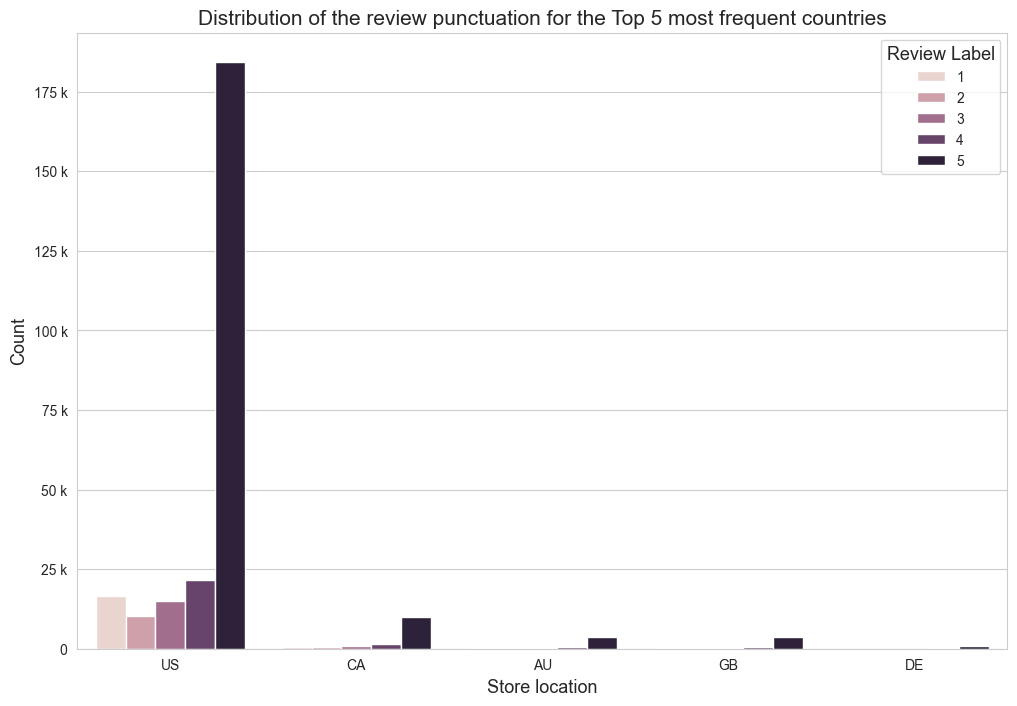

In [17]:
import matplotlib.ticker as ticker

# Plot of the distribution of the review-label for the top 5 countries more repeated
top_countries = df_eda['store_location'].value_counts().head(5).index
df_top_countries = df_eda[df_eda['store_location'].isin(top_countries)]

# Sort the data
df_top_countries = df_top_countries.sort_values('store_location')

# Create the plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.countplot(data=df_top_countries, x='store_location',
                   hue='review_label', order = df_top_countries['store_location'].value_counts().index)

# Add a legend, title and labels
plt.legend(title='Review Label', title_fontsize='13', loc='upper right')
plt.title('Distribution of the review punctuation for the Top 5 most frequent countries', size=15)
plt.xlabel('Store location', size=13)
plt.ylabel('Count', size=13)

# Improve y-axis with a "k" thousands format
ax.yaxis.set_major_formatter(ticker.EngFormatter())

plt.show()

In [18]:
# Aggregate data to get total reviews per store location
df_agg = df_eda.groupby(['store_location', 'latitude', 'longitude']).size().reset_index(name='review_count')

# Apply a logarithmic transformation to 'review_count'
df_agg['log_review_count'] = round(np.log(df_agg['review_count']), 1)

# Round the log_review_count to one decimal
df_agg['log_review_count_rounded'] = df_agg['log_review_count'].round(1)

# Create bubble map
fig = px.scatter_geo(df_agg,
                     lat='latitude',
                     lon='longitude',
                     color='log_review_count_rounded',
                     size='log_review_count',
                     hover_name='store_location',
                     hover_data={'log_review_count_rounded': True, 'review_count': True},
                     projection='natural earth',
                     title='Number of reviews per store location (Log scale)',
                     color_continuous_scale=px.colors.sequential.Plasma
)

# Add colorbar
fig.update_layout(coloraxis_colorbar=dict(title='Log of Review Count', tickformat='.1f'))

# Improve color scale
fig.update_traces(marker=dict(colorbar=dict(tickvals=[0, 2, 4, 6, 8], ticktext=['0', '100', '10000', '1000000', '100000000'])))

# Add title and labels
fig.update_layout(title_text="Number of reviews per store location (Log scale)",
                  xaxis_title="Longitude",
                  yaxis_title="Latitude")

# Add annotations
fig.add_annotation(
            x=0.5,
            y=-0.15,
            xref="paper",
            yref="paper",
            text="Size of bubbles represents the log of review count.",
            showarrow=False,
            font=dict(
                size=15,
                color="black"
            )
        )
fig.add_annotation(
            x=0.5,
            y=-0.19,
            xref="paper",
            yref="paper",
            text="This is made to better represent the data in the map.",
            showarrow=False,
            font=dict(
                size=15,
                color="black"
            )
        )

# Adjust the size and margins of the map
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=10
    )
)

fig.show()

# Shopper sentiment analysis

The variable

In [20]:
# Number of samples per class
n_samples = 10716

# Sample equally from each class
df_sentiment = df_sentiment.groupby('review_label').apply(lambda x: x.sample(n_samples)).reset_index(drop=True) # Undersample of the df_sentiment
df_sentiment['review_label'] = df_sentiment['review_label'].map({1:0, 2:1, 3:2, 4:3, 5:4})

In [ ]:
df_sentiment['store_location'].value_counts()

In [21]:
df_sentiment['review_label'].value_counts()

review_label
0    10716
1    10716
2    10716
3    10716
4    10716
Name: count, dtype: int64

In [22]:
# Convert the 'review_label' column to integer type
df_sentiment['review_label'] = df_sentiment['review_label'].astype(int)

# Split the dataset into features (X) and target (y)
X = df_sentiment.drop('review_label', axis=1)
y = df_sentiment['review_label']

In [23]:
# Define a function to tokenize text and remove stopwords
stop_words = set(stopwords.words('english'))

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if not word in stop_words]
    return ' '.join(tokens)

# Apply text preprocessing to the 'review' column
X['review'] = X['review'].apply(preprocess_text)
X['title'] = X['title'].apply(preprocess_text)

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [25]:
# Vecotorization of the X data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [26]:
# Preprocessing steps
from sklearn.preprocessing import MinMaxScaler

preprocess = ColumnTransformer(
    transformers=[
        ('text_review', TfidfVectorizer(), 'review'),    # TfidfVectorizer for 'review'
        ('text_title', TfidfVectorizer(), 'title'),      # TfidfVectorizer for 'title'
        ('text_location', TfidfVectorizer(), 'store_location'),  # TfidfVectorizer for 'store_location'
        ('scale_date', MinMaxScaler(), ['date']),  # MinMaxScaler for 'date'
        ('scale_month', MinMaxScaler(), ['month']),  # MinMaxScaler for 'month'
        ('scale_longitude', MinMaxScaler(), ['longitude']),  # MinMaxScaler for 'longitude'
        ('scale_latitude', MinMaxScaler(), ['latitude']),  # MinMaxScaler for 'latitude'
    ]
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# Models to use
model1 = RandomForestClassifier(n_estimators=300, max_depth=60, min_samples_split=3, min_samples_leaf=3)
model2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, subsample=0.5, max_depth=5)
model3 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=300, learning_rate=0.01, max_depth=6, gamma=0.5, subsample=0.6)

# Creating the pipeline
pipeline1 = Pipeline([
    ('preprocess', preprocess), # Preprocessing
    ('classifier', model1)       # Model
])

pipeline2 = Pipeline([
    ('preprocess', preprocess), # Preprocessing
    ('classifier', model2)       # Model
])

pipeline3 = Pipeline([
    ('preprocess', preprocess), # Preprocessing
    ('classifier', model3)       # Model
])

# Fit each pipeline
pipeline1.fit(X_train, y_train)
pipeline2.fit(X_train, y_train)
pipeline3.fit(X_train, y_train)

# Create the ensemble model with the fitted models
ensemble_model = VotingClassifier(estimators=[
    ('rf', pipeline1),
    ('gb', pipeline2),
    ('xgb', pipeline3)
], voting='soft')

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
predictions = ensemble_model.predict(X_test)

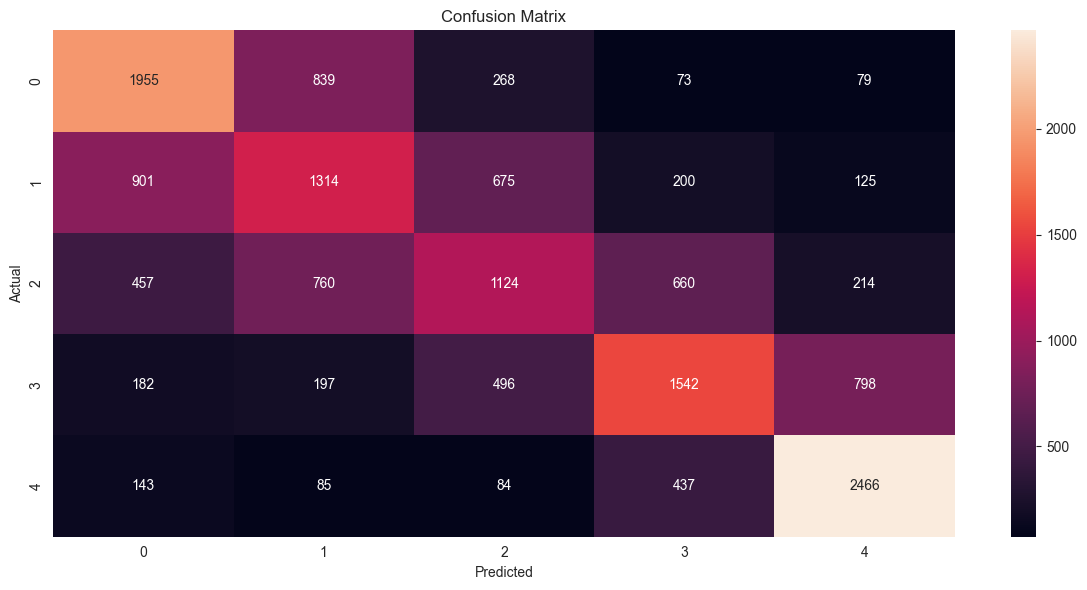

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [28]:
# Predictions on training set
train_predictions = ensemble_model.predict(X_train)

# Classification report for training set
train_report = classification_report(y_train, train_predictions)
print(f"Training Classification Report:\n{train_report}\n")

# Classification report for testing set
test_report = classification_report(y_test, predictions)
print(f"Testing Classification Report:\n{test_report}")

Training Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      7502
           1       0.68      0.65      0.66      7501
           2       0.71      0.60      0.65      7501
           3       0.71      0.64      0.68      7501
           4       0.75      0.87      0.81      7501

    accuracy                           0.71     37506
   macro avg       0.71      0.71      0.71     37506
weighted avg       0.71      0.71      0.71     37506


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57      3214
           1       0.41      0.41      0.41      3215
           2       0.42      0.35      0.38      3215
           3       0.53      0.48      0.50      3215
           4       0.67      0.77      0.72      3215

    accuracy                           0.52     16074
   macro avg       0.51      0.52      0.52     16074
weighted avg 